## Importing libraries

In [32]:
import pip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import datetime as dt

import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import StratifiedKFold

## Loading the data

In [26]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime(2023, 1, 1)

company = 'AAPL'

data = yf.download(company, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [27]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.347923,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.634834,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.213623,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.869293,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.041466,132079200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.477127,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.652435,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.674026,85438400


## Plotting the data

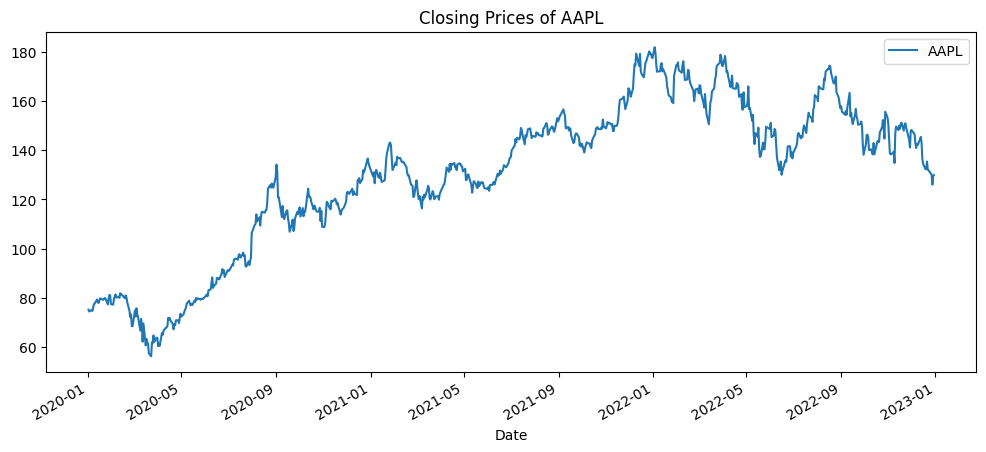

In [28]:
data['Close'].plot(label=company, figsize=(12,5), title=f"Closing Prices of {company}")
plt.legend()


## Preparing the dataset



In [29]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1)) # scaling the data

previous_days = 60 # number of days to look back 

x_train = []
y_train = []

for i in range(previous_days, len(scaled_data)):
    x_train.append(scaled_data[i - previous_days : i, 0]) # train with first 60 days 
    y_train.append(scaled_data[i, 0]) # try to guess next 60 days

x_train, y_train = np.array(x_train), np.array(y_train) # numpy array transformation
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 


## Building the model

In [30]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.25))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dropout(0.25))
model.add(Dense(units=1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32)
print(model.summary())

Epoch 1/5
22/22 [==============================] - 9s 94ms/step - loss: 0.0989
Epoch 2/5
22/22 [==============================] - 3s 154ms/step - loss: 0.0147
Epoch 3/5
22/22 [==============================] - 2s 94ms/step - loss: 0.0100
Epoch 4/5
22/22 [==============================] - 2s 93ms/step - loss: 0.0084
Epoch 5/5
22/22 [==============================] - 2s 94ms/step - loss: 0.0077
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0

## Testing the model accuracy on existing data

In [34]:
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(company, start=test_start, end=test_end)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - previous_days : ].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


[*********************100%***********************]  1 of 1 completed


## Making predictions on the test data

In [35]:
x_test = []
for x in range(previous_days, len(model_inputs)):
    x_test.append(model_inputs[x - previous_days : x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

27/27 [==============================] - 2s 27ms/step


## Plotting the test predictions

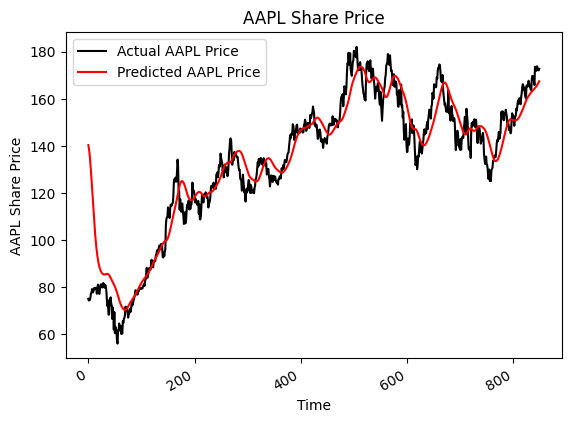

In [36]:
days = mdates.drange(test_start, test_end, dt.timedelta(days=1))

plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="red", label=f"Predicted {company} Price")
plt.gcf().autofmt_xdate()

plt.title(f"{company} Share Price")
plt.xlabel('Time')
plt.ylabel(f"{company} Share Price")
plt.legend()


plt.show()

## Mean Absolute Error

In [37]:
N = len(actual_prices)
yp = np.array(predicted_prices).flatten()
ya = actual_prices
res = sum(abs(ya-yp)) / N
print(res)

6.69029593075023


## Mean Squared Error

In [38]:
N = len(actual_prices)
yp = np.array(predicted_prices).flatten()
ya = actual_prices
res = sum((ya-yp)**2) / N
print(res)

93.60279102998847


## Mean Percentage Absolute Error

In [39]:
N = len(actual_prices)
yp = np.array(predicted_prices).flatten()
ya = actual_prices
res = (sum(abs(ya-yp)/yp)/N)*100
print(res)

5.19654675251995
